# A2 assignment's notebook for Complex Networks at URV 2025

## Authors:

- Lobo Santos, Antonio
-  Kasa, Andras


## Part 1: Characterization of the community structure of networks with block structure

In [2]:
# Import necessary libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)


#### Define SBM Parameters and Generate the Network

We first define our SBM parameters. The network is divided into 5 blocks of equal size. The intra-block connection probability (prr) is set to an example value of 0.16 and the inter-block connection probability (prs) is 0.02. A probability matrix is then built where diagonal entries correspond to `prr` and off-diagonals to `prs`.


In [2]:
# Define parameters
N = 300                   # Total number of nodes
nblocks = 5               # Number of blocks
block_size = N // nblocks # Equal block sizes
prr = 0.16                # Intra-block probability
prs = 0.02                # Inter-block probability

# Create list of block sizes
sizes = [block_size] * nblocks

# Create the probability matrix for SBM
p_matrix = [[prr if i == j else prs for j in range(nblocks)] for i in range(nblocks)]

# Print the parameters for verification
print("SBM Parameters:")
print(f"Total nodes: {N}")
print(f"Blocks: {nblocks}")
print(f"Block sizes: {sizes}")
print(f"Intra-block probability (prr): {prr}")
print(f"Inter-block probability (prs): {prs}")

SBM Parameters:
Total nodes: 300
Blocks: 5
Block sizes: [60, 60, 60, 60, 60]
Intra-block probability (prr): 0.16
Inter-block probability (prs): 0.02


### Generate the Synthetic SBM Network

We now use the `networkx.stochastic_block_model` function to generate our synthetic network with the specified SBM parameters.


In [3]:
def create_sbm_graph(N=300, nblocks=5, prr=0.16, prs=0.02, seed=None, save_pajek=False):
    """
    Generate a synthetic network using the stochastic block model (SBM) and return the NetworkX graph.
    
    Parameters:
    -----------
    N : int
        Total number of nodes.
    nblocks : int
        Number of blocks (communities). Assumes equal block sizes.
    prr : float
        Intra-block connection probability.
    prs : float
        Inter-block connection probability.
    seed : int or None
        Random seed for reproducibility.
    save_pajek : bool
        If True, the graph will be saved in Pajek format with a filename based on the parameters.
    
    Returns:
    --------
    G : networkx.Graph
        The generated SBM network.
    """
    block_size = N // nblocks
    sizes = [block_size] * nblocks

    # Create the probability matrix: prr for intra-block, prs for inter-block.
    p_matrix = [[prr if i == j else prs for j in range(nblocks)] for i in range(nblocks)]

    # Generate the SBM network using NetworkX.
    G = nx.stochastic_block_model(sizes, p_matrix, seed=seed)

    # Optionally, save the network in Pajek format.
    if save_pajek:
        filename = f"synthetic_network_N_{N}_blocks_{nblocks}_prr_{prr}_prs_{prs}.net"
        nx.write_pajek(G, filename)
    
    return G

G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=True)

# Print basic information about the generated network
print("Generated SBM Network:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Generated SBM Network:
Number of nodes: 300
Number of edges: 2182


c:\Users\Usuario\anaconda3\envs\CN\lib\site-packages\networkx\readwrite\pajek.py:75: UserWarning: Node attribute block is not processed. Non-string attribute.
  warnings.warn(


### Finding Communities
In this section we will focus on identifying the communities on the previously generated graphs. First we will compute all communities using the following algorithms:

1. Infomap
2. Louvain
3. Greedy Modularity 

In [10]:
import infomap as im



from collections import defaultdict

def infomap_to_networkx_communities(mapping,infomap_partition):
    community_dict = defaultdict(set)
    for node, community in infomap_partition.items():
        community_dict[community].add(mapping[node])
    
    return list(community_dict.values())
    
def get_all_communities(G, block_size, nblocks, silent_infomap=True):
    """
    Computes and returns communities detected with multiple methods on graph G.
    
    The methods include:
      - Infomap (using Infomap package)
      - Louvain (using networkx.community.louvain_communities)
      - Greedy modularity communities (using networkx.community.greedy_modularity_communities)
      - Golden standard communities (defined as blocks of nodes)
    
    Args:
        G (networkx.Graph): The graph on which to perform community detection.
        block_size (int): The size of each block for the golden standard.
        nblocks (int): The number of blocks for the golden standard.
        silent_infomap (bool): If True, disables output from Infomap.
    
    Returns:
        dict: A dictionary with keys 'infomap', 'louvain', 'greedy', and 'golden_standard' 
              mapping to the list of communities found by each method.
    """
    # INFOMAP
    infomap_wrapper = im.Infomap(silent=silent_infomap)
    mapping = infomap_wrapper.add_networkx_graph(G)
    infomap_wrapper.run()
    infomap_partition = infomap_wrapper.get_modules()
    communities_infomap = infomap_to_networkx_communities(mapping, infomap_partition)
    
    # LOUVAIN COMMUNITY
    communities_louvain = nx.community.louvain_communities(G)
    
    # GREEDY MODULARITY COMMUNITY
    communities_greedy = nx.community.greedy_modularity_communities(G)
    
    # GOLDEN STANDARD COMMUNITY
    communities_golden_standard = [set(range(i * block_size, (i + 1) * block_size)) for i in range(nblocks)]
    
    return {
        "infomap": communities_infomap,
        "louvain": communities_louvain,
        "greedy": communities_greedy,
        "golden_standard": communities_golden_standard
    }

communities = get_all_communities(G, block_size, nblocks)
    
# Print the communities for each method
for method, comm_list in communities.items():
    print(f"\nCommunities detected using {method}:")
    for idx, community in enumerate(comm_list):
        print(f"  Community {idx + 1}: {', '.join(map(str,community))}")

NameError: name 'G' is not defined

We define the evaluation functions to compute the metrics

In [21]:
from collections import defaultdict, Counter
from math import log
import networkx as nx
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import normalized_mutual_info_score

def partition_to_labels(partition):
    """
    Convert a partition (list of sets) into a dictionary mapping each node to its community id.
    """
    labels = {}
    for label, community in enumerate(partition):
        for node in community:
            labels[node] = label
    return labels

def compute_entropy(labels):
    counts = Counter(labels)
    total = len(labels)
    return -sum((count/total) * log(count/total) for count in counts.values() if count/total > 0)

def compute_mutual_information(y_true, y_pred):
    total = len(y_true)
    counter_true = Counter(y_true)
    counter_pred = Counter(y_pred)
    joint_counts = Counter(zip(y_true, y_pred))
    mi = 0.0
    for (t, p), joint in joint_counts.items():
        p_tp = joint / total
        p_t = counter_true[t] / total
        p_p = counter_pred[p] / total
        mi += p_tp * log(p_tp / (p_t * p_p))
    return mi

def normalized_variation_of_information(y_true, y_pred):
    """
    Compute the Variation of Information (VI) and then normalize it.
    VI = H(true) + H(pred) - 2I(true, pred). The normalized VI is obtained by dividing by log(n)
    where n is the number of nodes.
    """
    H_true = compute_entropy(y_true)
    H_pred = compute_entropy(y_pred)
    I = compute_mutual_information(y_true, y_pred)
    VI = H_true + H_pred - 2 * I
    normalization = log(len(y_true))
    return VI / normalization if normalization != 0 else VI

def jaccard_index_partition(y_true, y_pred):
    """
    Compute a pair-count based Jaccard Index for two partitions.
    For all pairs of nodes, count a pair if the nodes are in the same community in one or both 
    partitions, and count an agreement if they are together in both.
    """
    n = len(y_true)
    agree = 0  # pairs that are in the same community in both partitions
    union = 0  # pairs that are in the same community in at least one partition
    for i in range(n):
        for j in range(i + 1, n):
            same_true = (y_true[i] == y_true[j])
            same_pred = (y_pred[i] == y_pred[j])
            if same_true or same_pred:
                union += 1
            if same_true and same_pred:
                agree += 1
    return agree / union if union != 0 else 0

def evaluate_partition(golden_partition, algorithm_partition, G, prr):
    """
    Evaluate a community partition against the golden standard.
    
    Arguments:
        golden_partition: List[Set] representing the true communities.
        algorithm_partition: List[Set] representing communities found by an algorithm.
        G: networkx graph for computing modularity.
        prr: A parameter (e.g., node removal probability) to track the evolution.
    
    Returns:
        dict: A dictionary containing:
            - 'prr': given prr value.
            - 'num_communities': number of communities in the algorithm partition.
            - 'modularity': modularity of the algorithm partition.
            - 'normalized_mutual_information': NMI between golden and algorithm partitions.
            - 'normalized_variation_of_information': normalized VI between partitions.
            - 'jaccard_index': Jaccard index for the partitions (pair-based).
    """
    metrics = {}
    metrics['prr'] = prr
    metrics['num_communities'] = len(algorithm_partition)
    
    # Compute modularity using networkx
    metrics['modularity'] = modularity(G, algorithm_partition)
    
    # Convert partitions to label assignments
    alg_labels_dict = partition_to_labels(algorithm_partition)
    golden_labels_dict = partition_to_labels(golden_partition)
    
    # Ensure both partitions cover the same set of nodes;
    # here we assume that golden_partition contains all nodes.
    common_nodes = list(golden_labels_dict.keys())
    
    y_true = [golden_labels_dict[node] for node in common_nodes]
    y_pred = [alg_labels_dict[node] for node in common_nodes]
    
    # Compute Normalized Mutual Information (using arithmetic normalization)
    metrics['normalized_mutual_information'] = normalized_mutual_info_score(
        y_true, y_pred, average_method='arithmetic'
    )
    
    # Compute Normalized Variation of Information
    metrics['normalized_variation_of_information'] = normalized_variation_of_information(y_true, y_pred)
    
    # Compute Jaccard Index for community partitions
    metrics['jaccard_index'] = jaccard_index_partition(y_true, y_pred)
    
    return metrics

evaluate_partition(communities["golden_standard"], communities["infomap"], G, prr)

NameError: name 'communities' is not defined

Now we are going to plot each of the error metrics with respect to prr

In [42]:
def iterate_and_plot(
    step=0.02
):
    """
    Iterates prr from 0 to 1 (inclusive) with the given step and computes evaluation metrics
    for Infomap, Louvain, and Greedy community detection algorithms. It then plots each metric
    (normalized_mutual_information, normalized_variation_of_information, jaccard_index, modularity,
    and number of communities) in a separate plot as a function of prr.
    
    Arguments:
        step: Step size for prr (default is 0.02)
        
    Returns:
        None. The function creates plots.
    """
    
    # List to store prr values and the corresponding metric for each algorithm
    prr_values = []
    
    im_nmi   = []
    lv_nmi   = []
    gr_nmi   = []
    
    im_vi    = []
    lv_vi    = []
    gr_vi    = []
    
    im_jaccard = []
    lv_jaccard = []
    gr_jaccard = []
    
    im_modularity = []
    lv_modularity = []
    gr_modularity = []
    
    im_num_comm = []
    lv_num_comm = []
    gr_num_comm = []
    
    # Iterate over prr from 0 to 1 (inclusive)
    for prr in np.arange(0, 1 + step, step):
        prr_values.append(prr)

        # Create a new SBM graph with the current prr value
        G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=False)
        
        # Compute communities using different algorithms
        communities = get_all_communities(G, block_size, nblocks, silent_infomap=True)
        # Compute evaluation metrics for each algorithm
        metrics_infomap = evaluate_partition(communities["golden_standard"], communities["infomap"], G, prr)
        metrics_louvain = evaluate_partition(communities["golden_standard"], communities["louvain"], G, prr)
        metrics_greedy  = evaluate_partition(communities["golden_standard"], communities["greedy"],  G, prr)
        
        # Append Normalized Mutual Information (NMI)
        im_nmi.append(metrics_infomap['normalized_mutual_information'])
        lv_nmi.append(metrics_louvain['normalized_mutual_information'])
        gr_nmi.append(metrics_greedy['normalized_mutual_information'])
        
        # Append Normalized Variation of Information (VI)
        im_vi.append(metrics_infomap['normalized_variation_of_information'])
        lv_vi.append(metrics_louvain['normalized_variation_of_information'])
        gr_vi.append(metrics_greedy['normalized_variation_of_information'])
        
        # Append Jaccard index
        im_jaccard.append(metrics_infomap['jaccard_index'])
        lv_jaccard.append(metrics_louvain['jaccard_index'])
        gr_jaccard.append(metrics_greedy['jaccard_index'])
        
        # Append modularity values
        im_modularity.append(metrics_infomap['modularity'])
        lv_modularity.append(metrics_louvain['modularity'])
        gr_modularity.append(metrics_greedy['modularity'])
        
        # Append number of communities found
        im_num_comm.append(metrics_infomap['num_communities'])
        lv_num_comm.append(metrics_louvain['num_communities'])
        gr_num_comm.append(metrics_greedy['num_communities'])
    
    # Plot Normalized Mutual Information vs prr
    plt.figure()
    plt.plot(prr_values, im_nmi, label='Infomap')
    plt.plot(prr_values, lv_nmi, label='Louvain')
    plt.plot(prr_values, gr_nmi, label='Greedy')
    plt.xlabel("prr")
    plt.ylabel("Normalized Mutual Information")
    plt.title("NMI vs prr")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Normalized Variation of Information vs prr
    plt.figure()
    plt.plot(prr_values, im_vi, label='Infomap')
    plt.plot(prr_values, lv_vi, label='Louvain')
    plt.plot(prr_values, gr_vi, label='Greedy')
    plt.xlabel("prr")
    plt.ylabel("Normalized Variation of Information")
    plt.title("Normalized VI vs prr")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Jaccard Index vs prr
    plt.figure()
    plt.plot(prr_values, im_jaccard, label='Infomap')
    plt.plot(prr_values, lv_jaccard, label='Louvain')
    plt.plot(prr_values, gr_jaccard, label='Greedy')
    plt.xlabel("prr")
    plt.ylabel("Jaccard Index")
    plt.title("Jaccard Index vs prr")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Modularity vs prr
    plt.figure()
    plt.plot(prr_values, im_modularity, label='Infomap')
    plt.plot(prr_values, lv_modularity, label='Louvain')
    plt.plot(prr_values, gr_modularity, label='Greedy')
    plt.xlabel("prr")
    plt.ylabel("Modularity")
    plt.title("Modularity vs prr")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Number of Communities vs prr
    plt.figure()
    plt.plot(prr_values, im_num_comm, label='Infomap')
    plt.plot(prr_values, lv_num_comm, label='Louvain')
    plt.plot(prr_values, gr_num_comm, label='Greedy')
    plt.xlabel("prr")
    plt.ylabel("Number of Communities")
    plt.title("Number of Communities vs prr")
    plt.legend()
    plt.grid(True)
    plt.show()



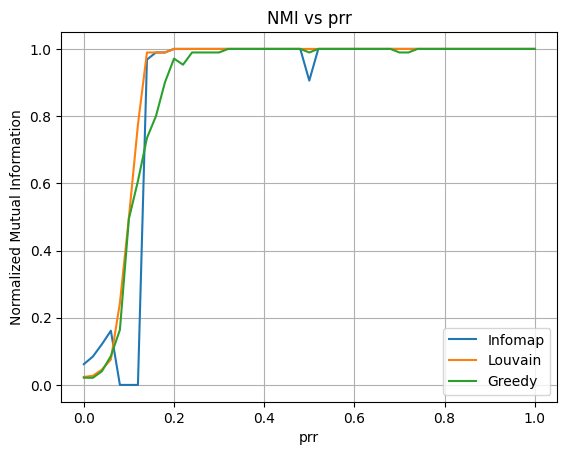

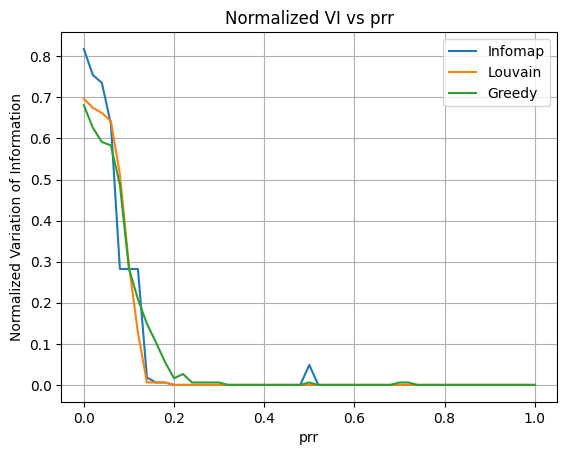

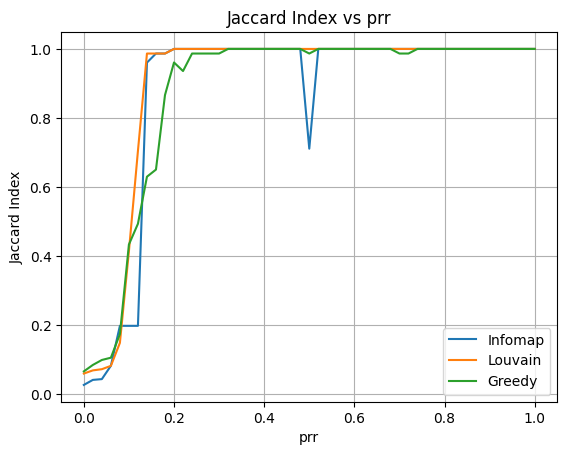

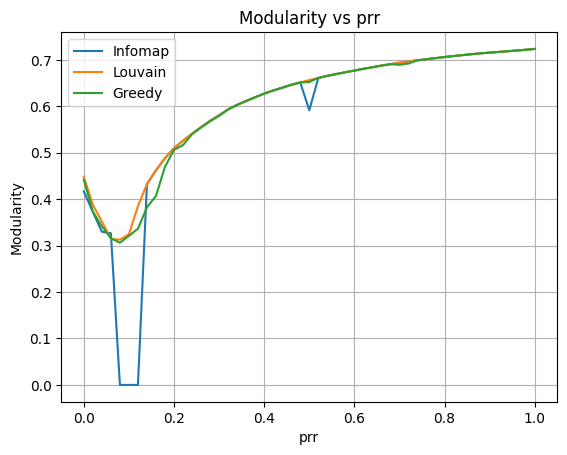

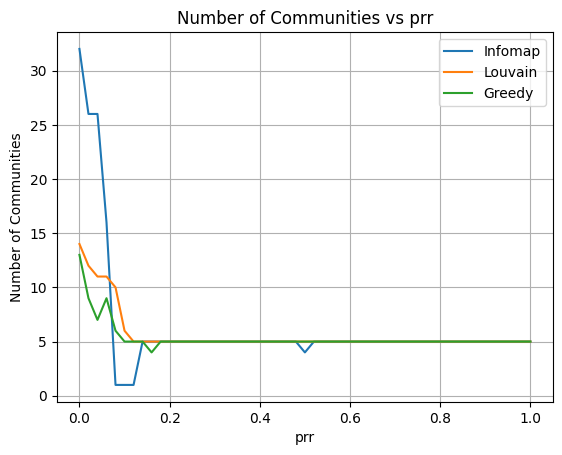

In [43]:
iterate_and_plot()

### TODO: Plot with colors

In [17]:
def set_color_nodes(communities,G):
    colors=plt.cm.jet(np.linspace(0,1,len(communities))) ## Get the colors for the communities
    community_node={} ## Dictionary to store the community of each node
    count_community=0 ## Counter for the communities' labels

    for community in communities: ## For each community
        for node in community: ## For each node in the community
            community_node[node]=count_community ## Store the label of the community of the node
        count_community=count_community+1 ## Update the counter

    color_nodes=[] ## List to store the color of each node
    for node in G.nodes():  
        color_nodes.append(colors[community_node[node]]) ## Get the color of the node

    return color_nodes


In [ ]:
# colors_node_louvain=set_color_nodes(communities_louvain,G)
# colors_node_greedy=set_color_nodes(communities_greedy,G)
# colors_node_infomap=set_color_nodes(communities_infomap,G)

## Part 2: Characterization of the community structure of real networks

In [ ]:
# Read unweighted and weighted networks from Pajek files along with metadata
G_u = nx.read_pajek("primaryschoolnetworks/primaryschool_u.net")
G_w = nx.read_pajek("primaryschoolnetworks/primaryschool_w.net")

# Read metadata from the txt file
metadata = {}
with open("primaryschoolnetworks/metadata_primary_school.txt", "r") as f:
    next(f)  # Skip header line
    for line in f:
        node, group = line.strip().split()
        metadata[node] = group

# Add metadata as node attributes
nx.set_node_attributes(G_u, metadata, "school_group")
nx.set_node_attributes(G_w, metadata, "school_group")

# Print basic information about both networks
print("Unweighted network:")
print(f"Number of nodes: {G_u.number_of_nodes()}")
print(f"Number of edges: {G_u.number_of_edges()}")
print("\nWeighted network:")
print(f"Number of nodes: {G_w.number_of_nodes()}")
print(f"Number of edges: {G_w.number_of_edges()}")

# Print unique school groups and their sizes
school_groups = {}
for node in G_u.nodes():
    group = G_u.nodes[node]["school_group"]
    school_groups[group] = school_groups.get(group, 0) + 1

print("\nSchool groups distribution:")
for group, count in sorted(school_groups.items()):
    print(f"{group}: {count} people")

Unweighted network:
Number of nodes: 242
Number of edges: 8317

Weighted network:
Number of nodes: 242
Number of edges: 8317

School groups distribution:
1A: 23 people
1B: 25 people
2A: 23 people
2B: 26 people
3A: 23 people
3B: 22 people
4A: 21 people
4B: 23 people
5A: 22 people
5B: 24 people
Teachers: 10 people


In [8]:
def run_infomap(G, use_weight=True):
    """
    Runs the Infomap algorithm on graph G.
    
    Parameters:
      G (networkx.Graph): The input graph.
      use_weight (bool): Whether to consider edge weights or run on an unweighted version.
      
    Returns:
      communities: List of sets (communities detected by Infomap)
    """
    im_wrapper = im.Infomap(silent=True)
    # When weights are not used, we pass weight=None so that each edge is treated equally.
    if use_weight:
        mapping = im_wrapper.add_networkx_graph(G)
    else:
        mapping = im_wrapper.add_networkx_graph(G, weight=None)
    im_wrapper.run()
    partition = im_wrapper.get_modules()
    communities = infomap_to_networkx_communities(mapping, partition)
    return communities

In [52]:

def metadata_to_communities(G, attribute="school_group"):
    """
    Converts node metadata into a community structure.
    
    Parameters:
        G (networkx.Graph): The input graph with metadata stored as node attributes.
        attribute (str): The key used to extract the metadata (default is "school_group").
        
    Returns:
        communities (list of sets): A list of communities, where each community is a set
                                    of nodes that share the same metadata value.
    """
    communities = {}
    for node in G.nodes():
        group = G.nodes[node].get(attribute)
        if group is not None:
            if group not in communities:
                communities[group] = set()
            communities[group].add(node)
    # Return only the sets of nodes (discard the keys)
    return list(communities.values())




def compare_all_community_structures(G_u, G_w, school_groups):
    """
    Computes several community detection partitions on the weighted and unweighted versions
    of the network and plots them for comparison. Each row corresponds to a method (Infomap,
    Louvain, Greedy Modularity, Golden Standard) and each row has two columns: left is for the
    weighted graph partition and right is for the unweighted one.
    
    Parameters:
      G_u (networkx.Graph): Unweighted version of the graph.
      G_w (networkx.Graph): Weighted version of the graph.
      school_groups (list of sets): Golden standard groups (typically based on metadata).
    
    Returns:
      None (displays a matplotlib figure).
    """
    # --- Prepare layout using the weighted graph.
    # Compute an "inverse weight" attribute (to use with Kamada–Kawai layout)
    for u, v, data in G_w.edges(data=True):
        weight = data.get('weight', 1)
        data['inv_weight'] = 1.0 / weight if weight != 0 else 0.0
    pos = nx.kamada_kawai_layout(G_w, weight='inv_weight')

    # --- Compute community partitions.
    # Infomap communities.
    communities_infomap_weighted = run_infomap(G_w, use_weight=True)
    communities_infomap_unweighted = run_infomap(G_u, use_weight=False)
    
    # Louvain communities. (Note: the unweighted detection is done by not passing a weight.)
    communities_louvain_weighted = nx.community.louvain_communities(G_w, weight='weight')
    communities_louvain_unweighted = nx.community.louvain_communities(G_u)
    
    # Greedy modularity communities.
    communities_greedy_weighted = nx.community.greedy_modularity_communities(G_w, weight='weight')
    communities_greedy_unweighted = nx.community.greedy_modularity_communities(G_u)
    
    # Golden standard communities (from metadata).
    # Here we assume that the golden standard groups are defined independently of weighting.
    communities_golden_weighted = school_groups
    communities_golden_unweighted = school_groups

    # Create a dictionary to easily loop over the community detection methods.
    methods = {
        "Infomap": (communities_infomap_weighted, communities_infomap_unweighted),
        "Louvain": (communities_louvain_weighted, communities_louvain_unweighted),
        "Greedy Modularity": (communities_greedy_weighted, communities_greedy_unweighted),
        "Golden Standard": (communities_golden_weighted, communities_golden_unweighted)
    }

    # --- Plotting.
    # Create a figure with one row per method and two columns.
    num_methods = len(methods)
    fig, axes = plt.subplots(num_methods, 2, figsize=(16, 4 * num_methods))
    # In case there's only one method, ensure axes is 2D.
    if num_methods == 1:
        axes = np.array([axes])

    for i, (method_name, (comm_w, comm_u)) in enumerate(methods.items()):
        # Get node colors for the weighted and unweighted community partitions.
        colors_weighted = set_color_nodes(comm_w, G_w)
        colors_unweighted = set_color_nodes(comm_u, G_w)
        
        # Compute modularity for quality assessment.
        mod_weighted = nx.algorithms.community.modularity(G_w, comm_w, weight='weight')
        mod_unweighted = nx.algorithms.community.modularity(G_u, comm_u, weight=None)
        
        # Plot weighted network.
        ax_left = axes[i, 0]
        nx.draw_networkx_edges(G_w, pos, alpha=0.3, edge_color="gray", ax=ax_left)
        nx.draw_networkx_nodes(G_w, pos, node_color=colors_weighted, node_size=200, ax=ax_left)
        ax_left.set_title(f"{method_name} (Weighted)\nModularity = {mod_weighted:.4f}")
        ax_left.axis('off')
        
        # Plot unweighted network.
        ax_right = axes[i, 1]
        nx.draw_networkx_edges(G_w, pos, alpha=0.3, edge_color="gray", ax=ax_right)
        nx.draw_networkx_nodes(G_w, pos, node_color=colors_unweighted, node_size=200, ax=ax_right)
        ax_right.set_title(f"{method_name} (Unweighted)\nModularity = {mod_unweighted:.4f}")
        ax_right.axis('off')
        
    plt.tight_layout()
    plt.show()

community_golden_standard = metadata_to_communities(G_u, attribute="school_group")

compare_all_community_structures(G_u, G_w, community_golden_standard)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002103F2041F0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Infomap detects only one community in the unweighted network, probably the network is almost fully connected and the algorithm can't identify bottlenecks on the random  walks.

In [4]:
n = G_u.number_of_nodes()
max_edges = (n-1)*n/2
density = G_u.number_of_edges()/max_edges
print(f"Density of the unweighted network: {density:.4f}")

Density of the unweighted network: 0.2852


Plotting for Infomap - Weighted communities


<Figure size 1000x600 with 0 Axes>

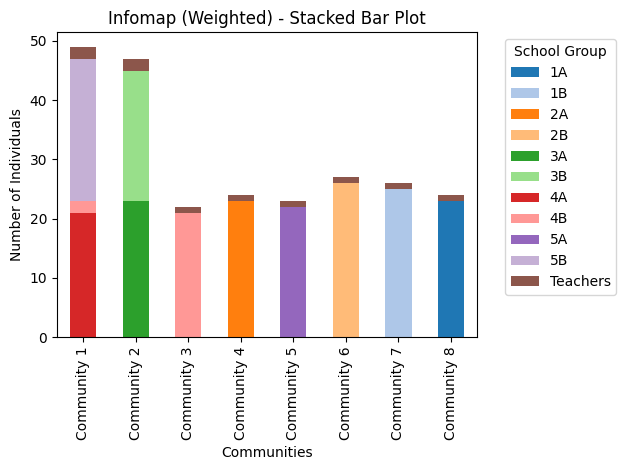

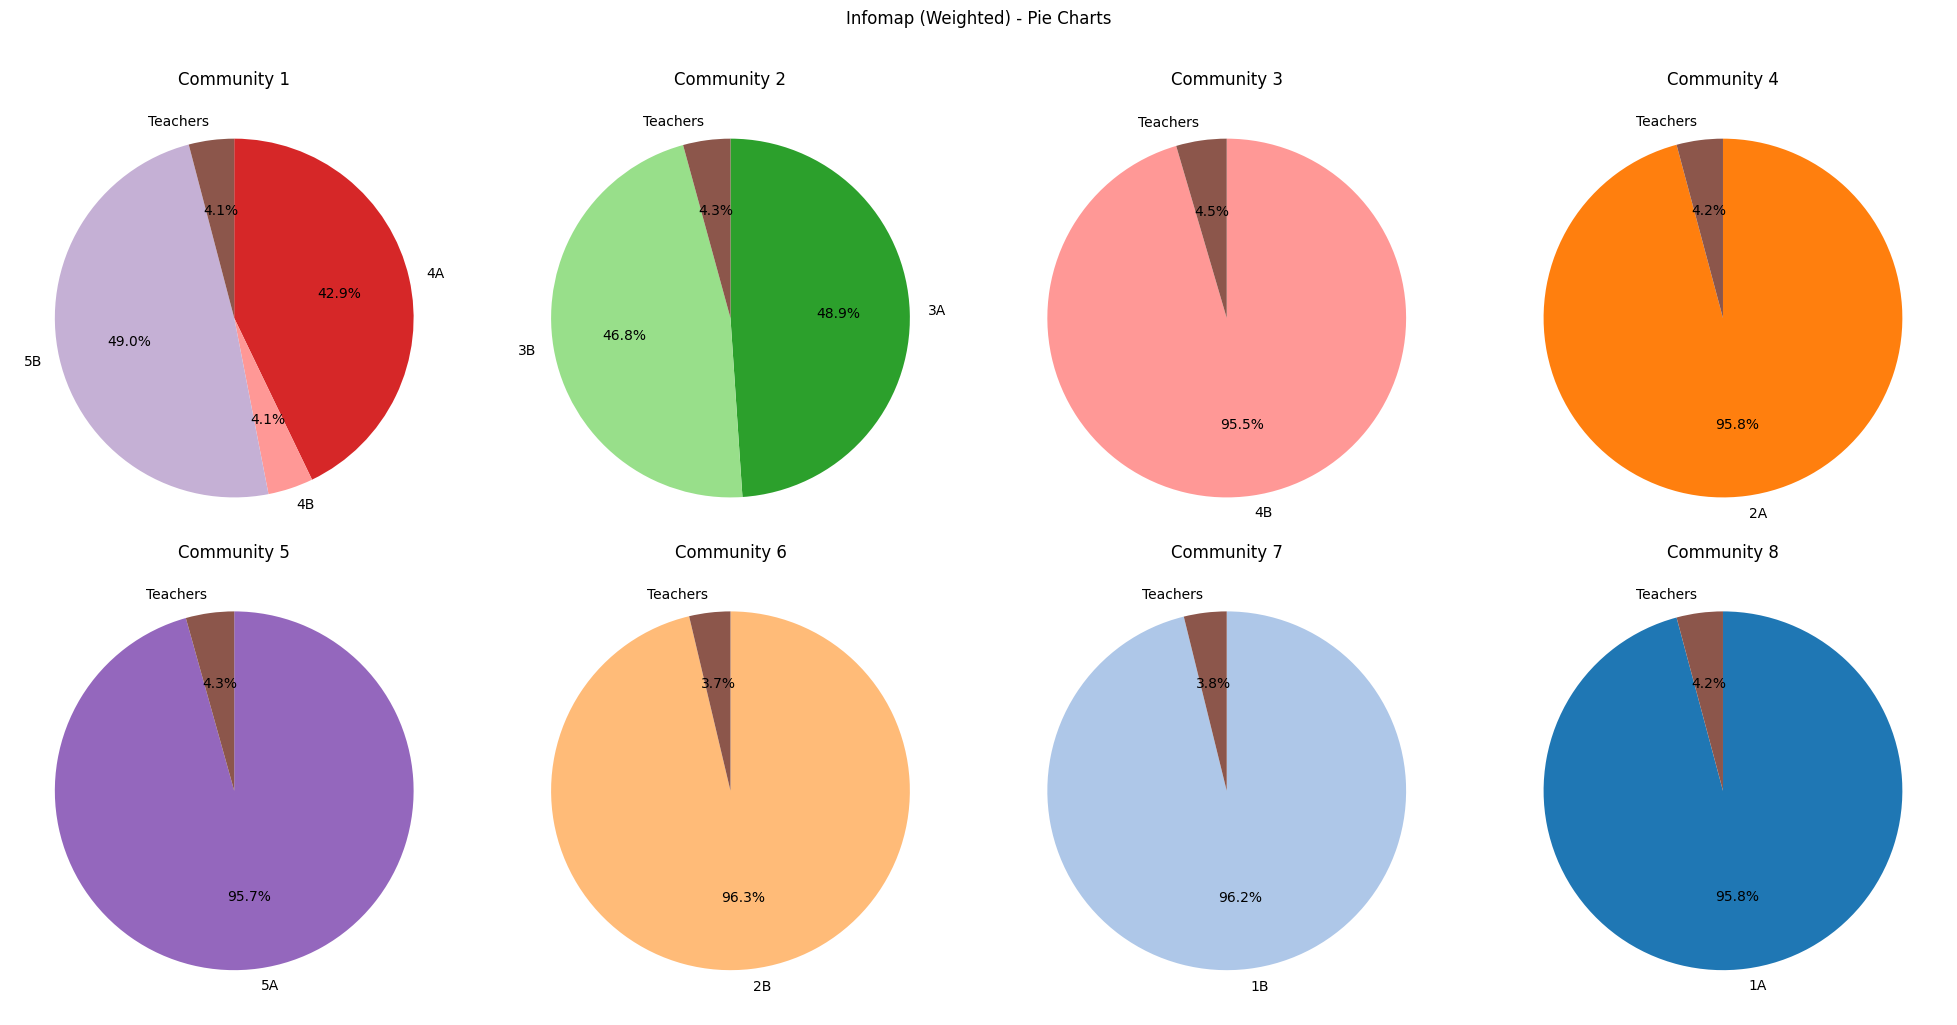

<Figure size 1000x600 with 0 Axes>

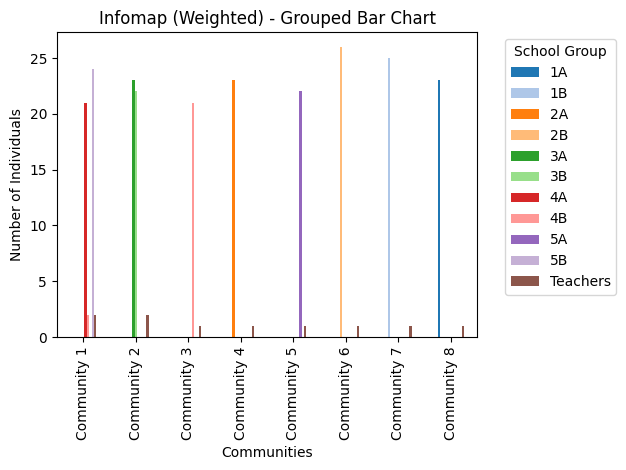

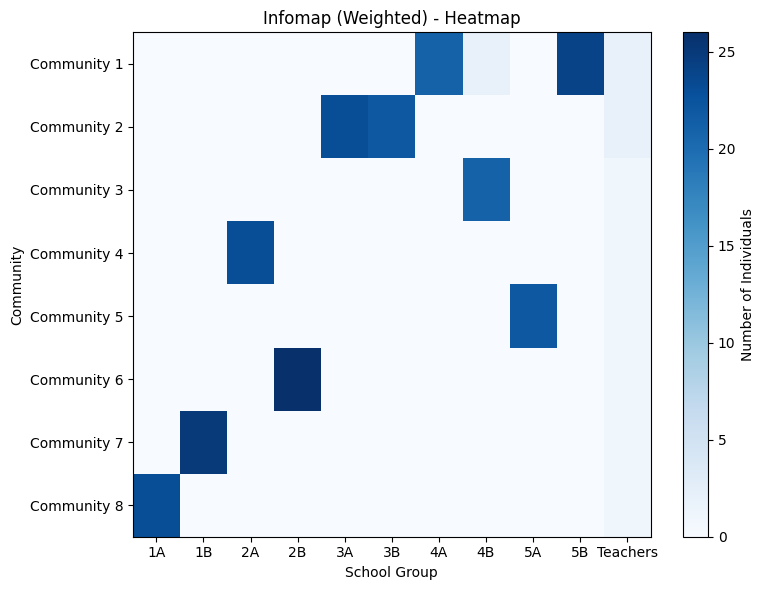

Plotting for Infomap - Unweighted communities


<Figure size 1000x600 with 0 Axes>

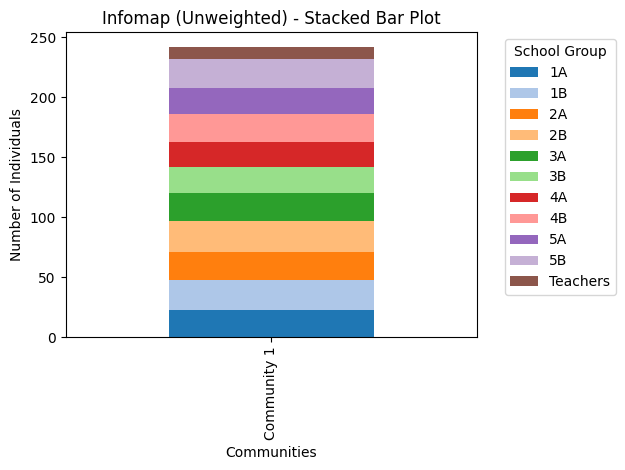

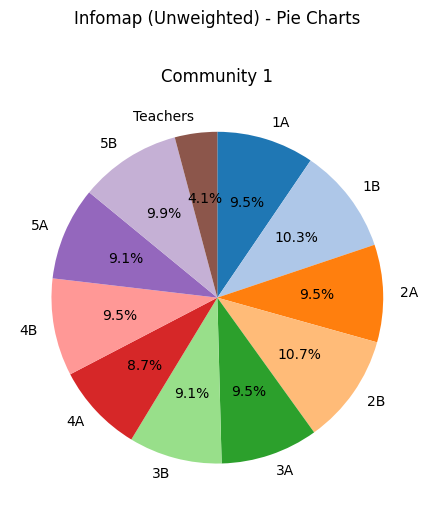

<Figure size 1000x600 with 0 Axes>

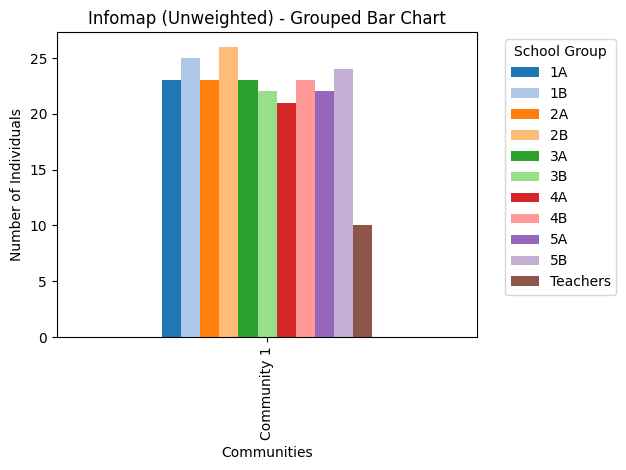

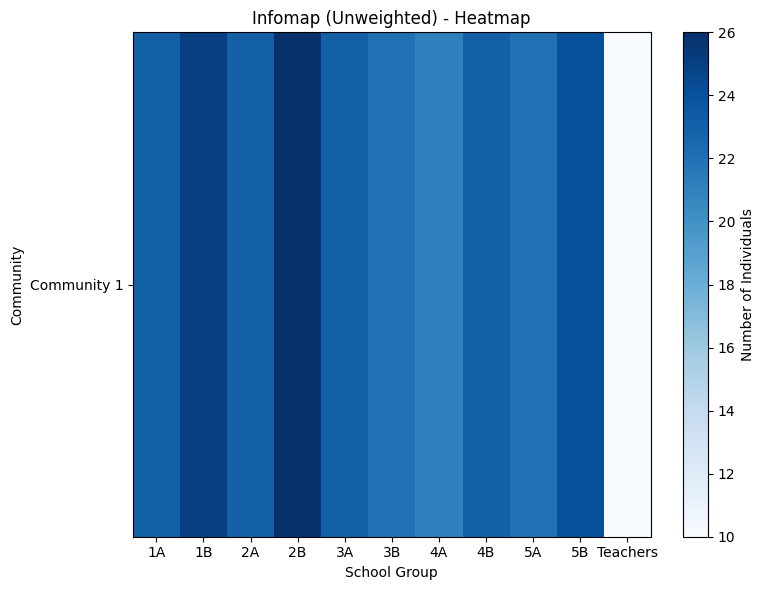

Plotting for Louvain - Weighted communities


<Figure size 1000x600 with 0 Axes>

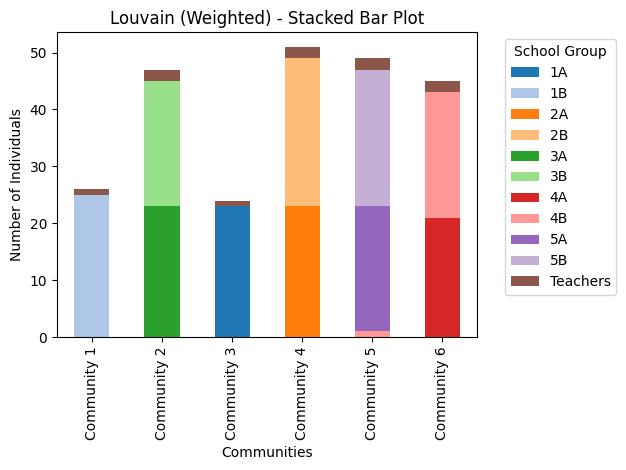

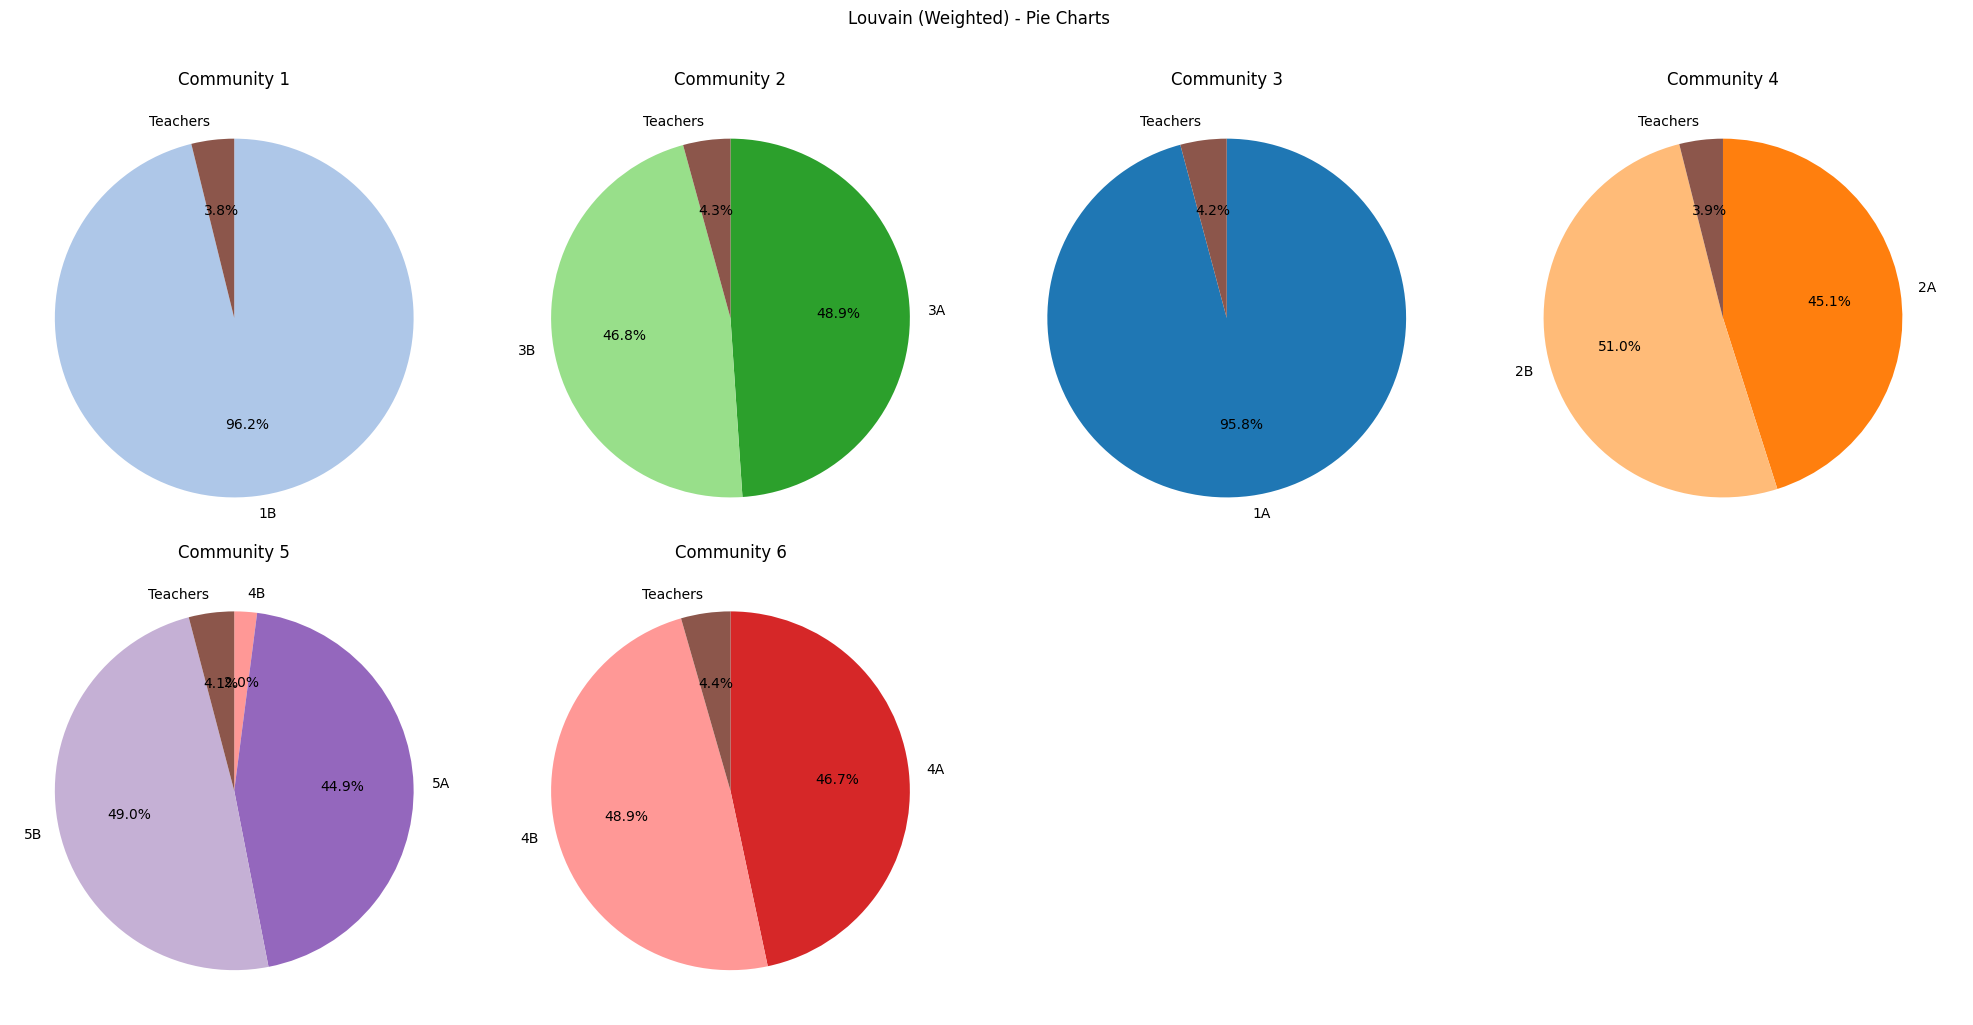

<Figure size 1000x600 with 0 Axes>

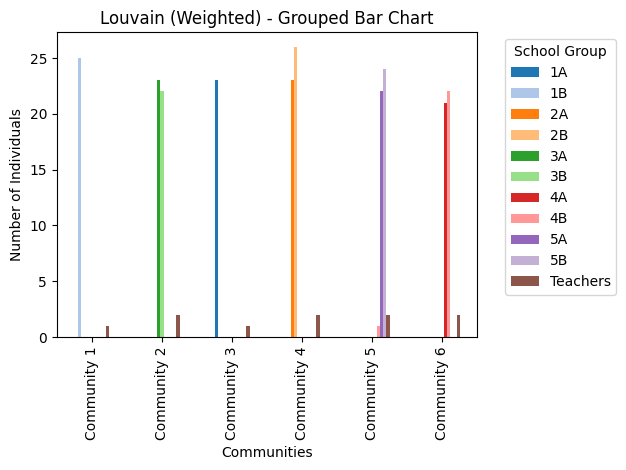

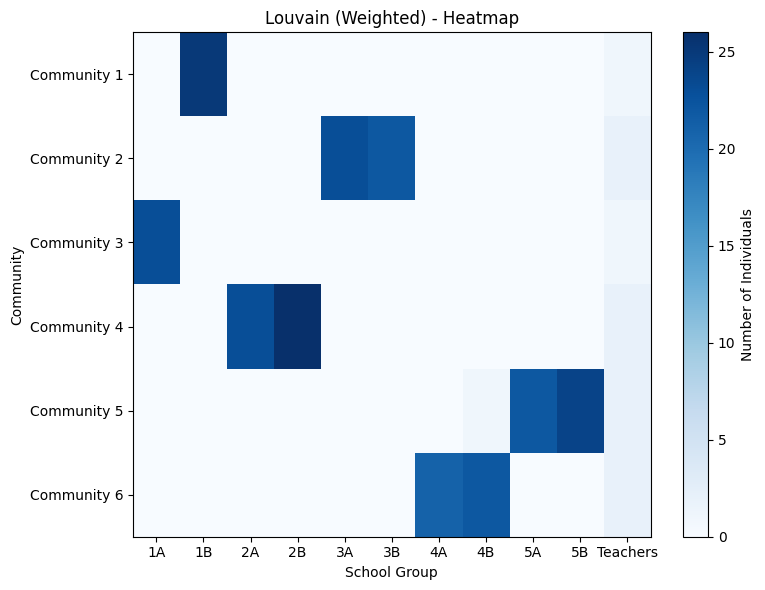

Plotting for Louvain - Unweighted communities


<Figure size 1000x600 with 0 Axes>

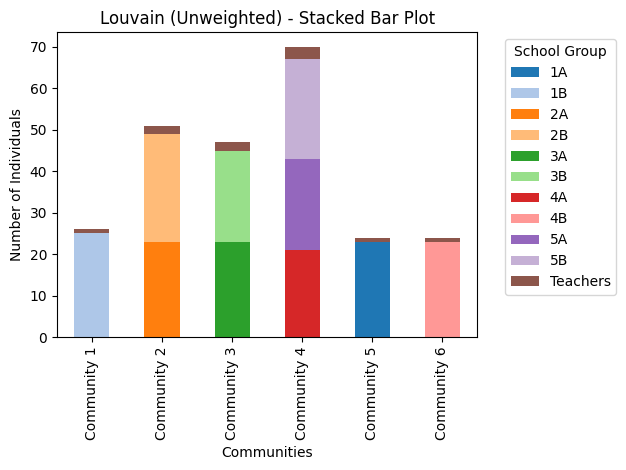

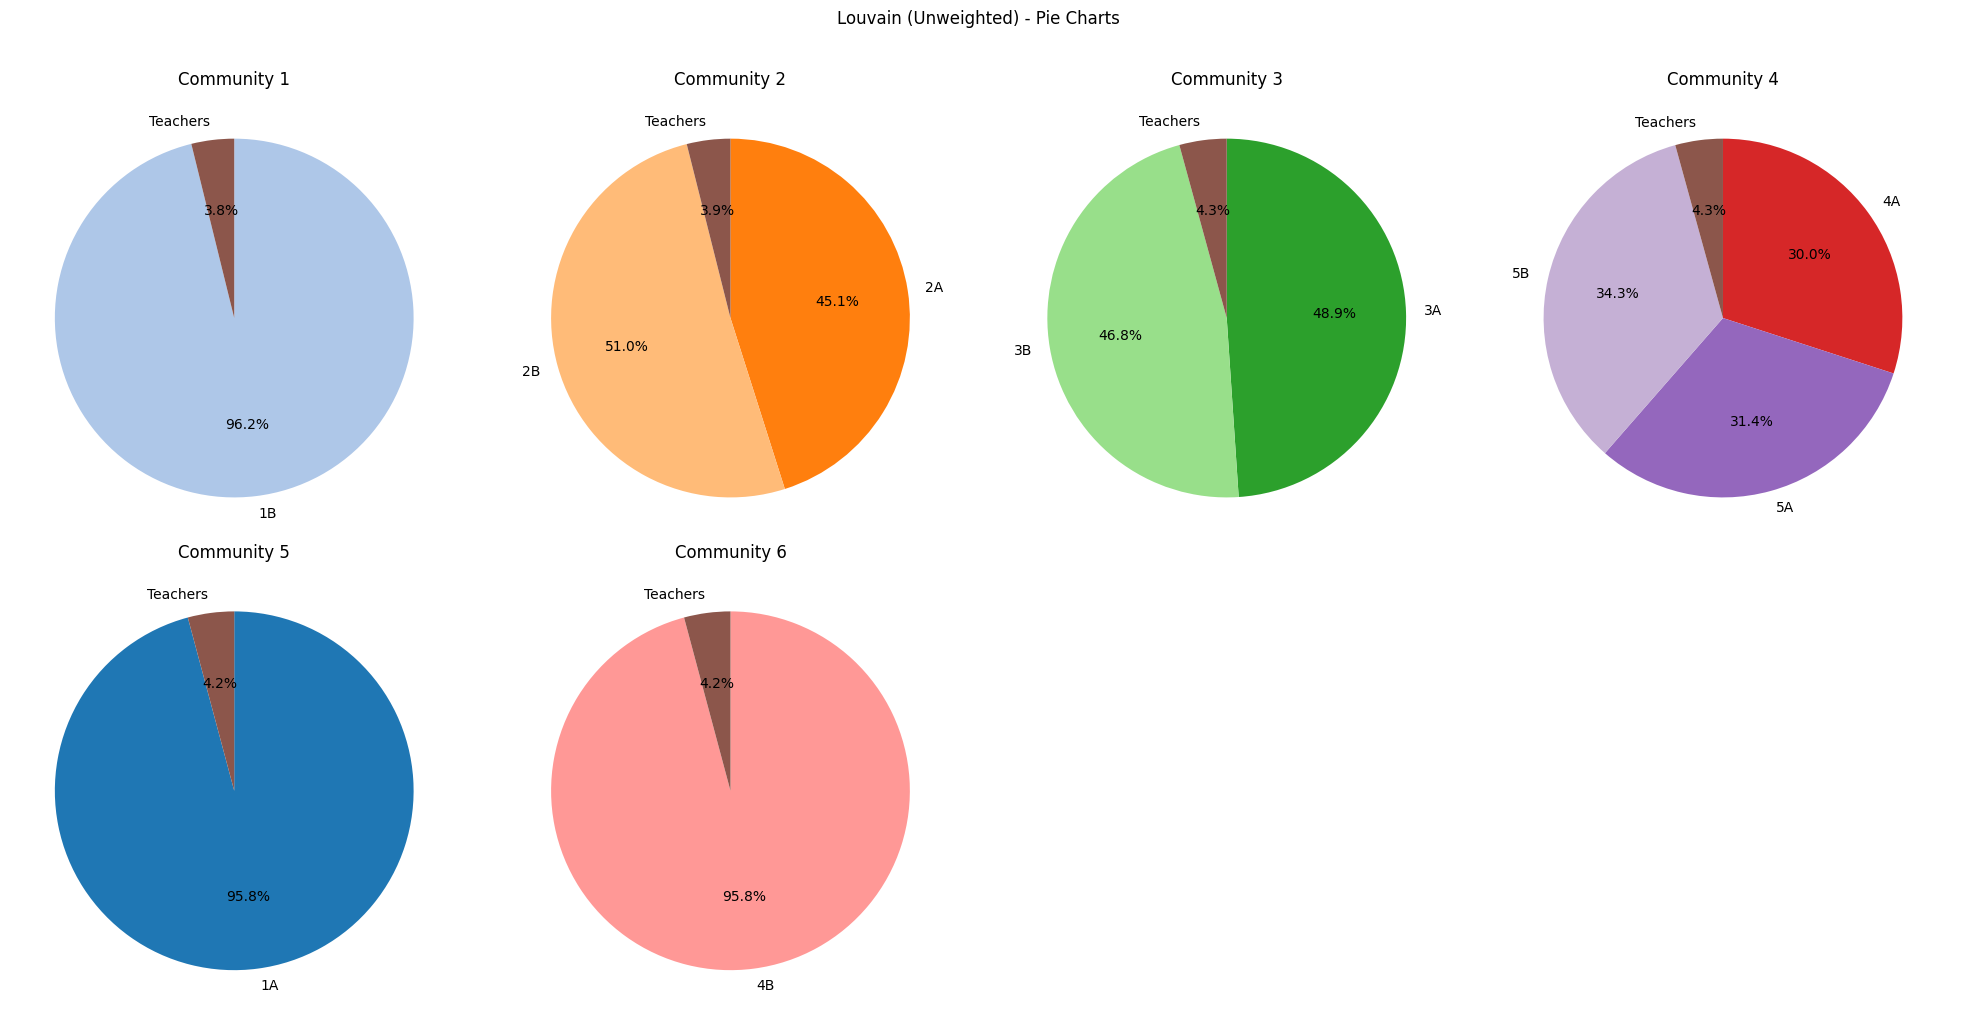

<Figure size 1000x600 with 0 Axes>

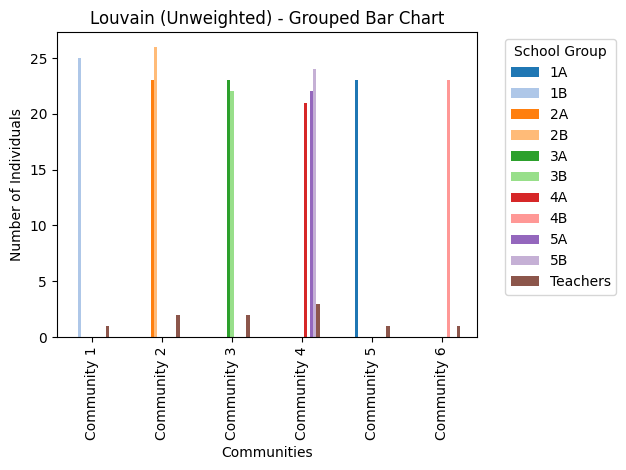

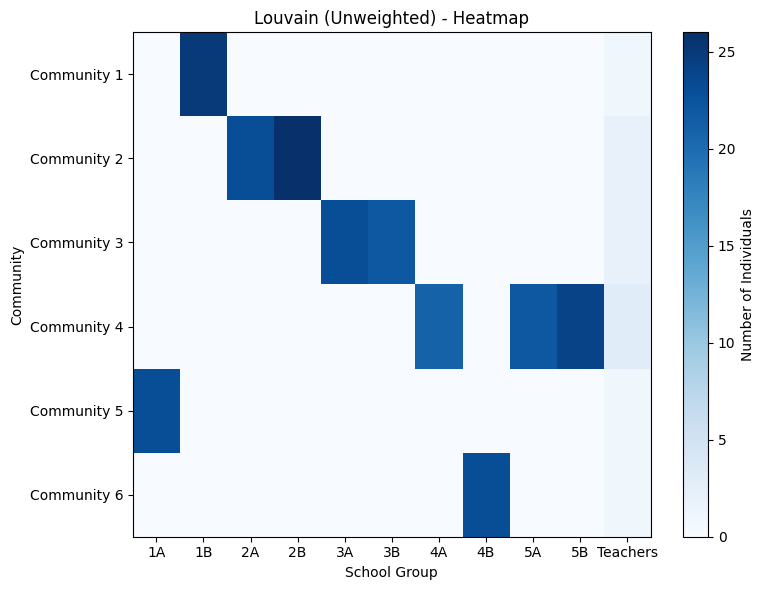

Plotting for Greedy Modularity - Weighted communities


<Figure size 1000x600 with 0 Axes>

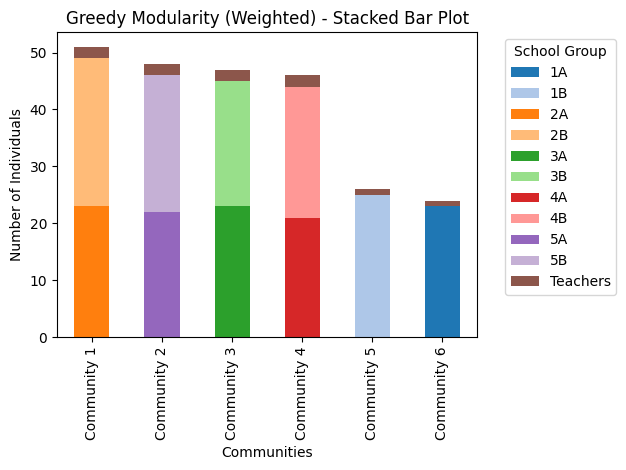

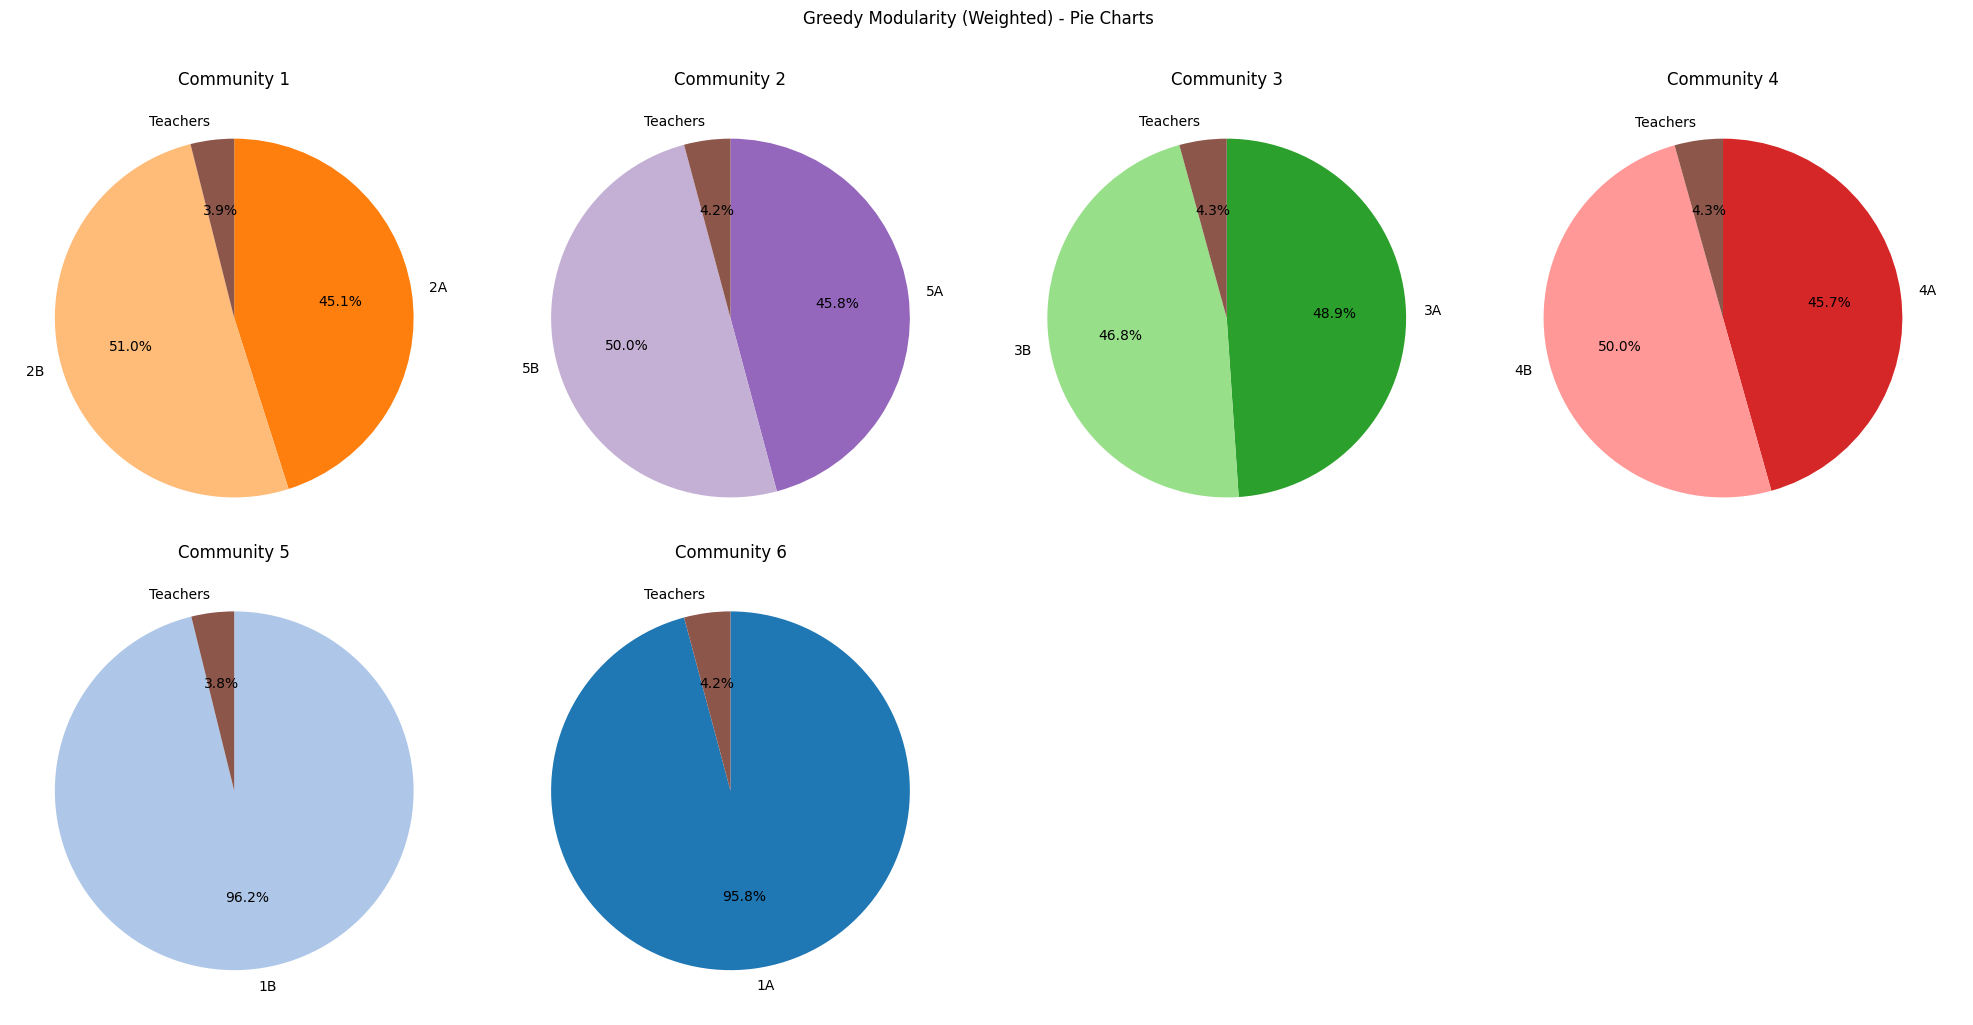

<Figure size 1000x600 with 0 Axes>

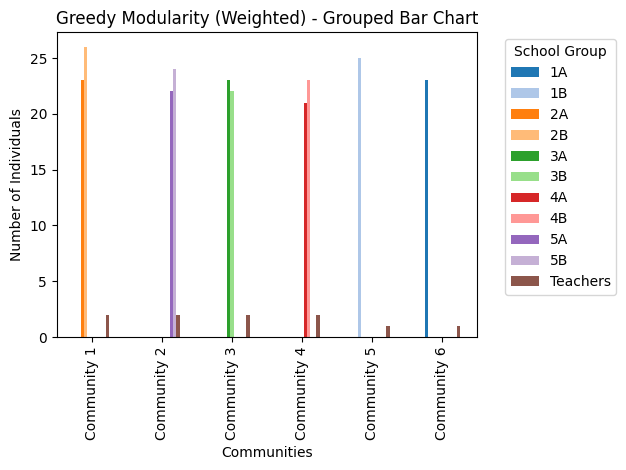

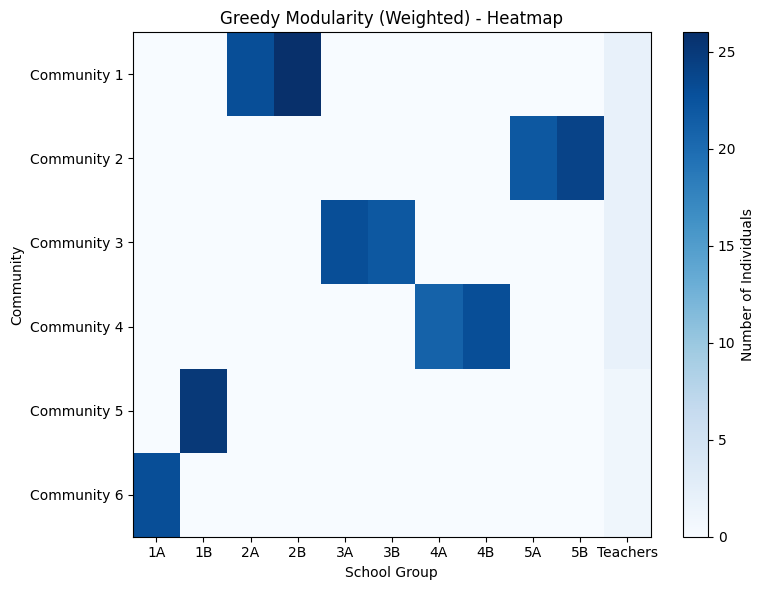

Plotting for Greedy Modularity - Unweighted communities


<Figure size 1000x600 with 0 Axes>

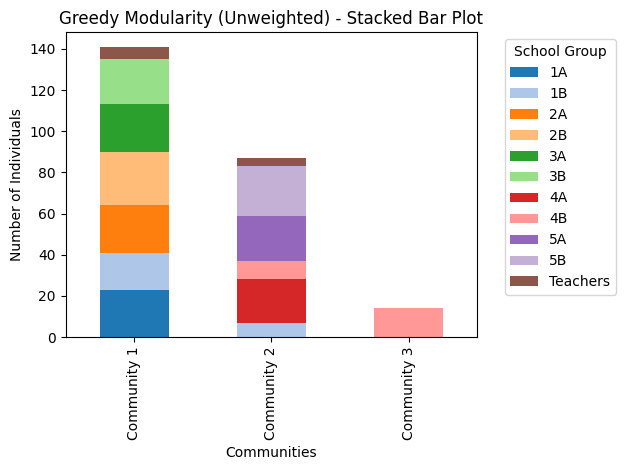

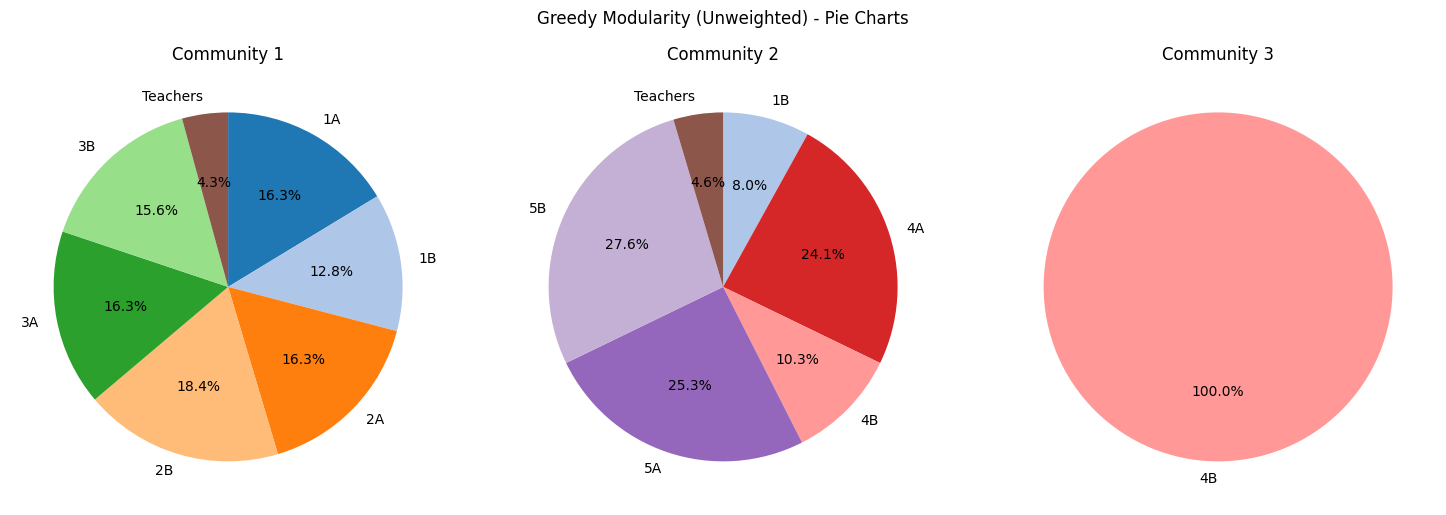

<Figure size 1000x600 with 0 Axes>

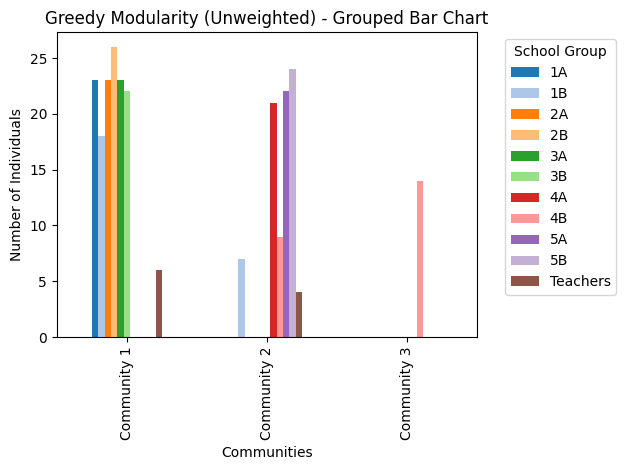

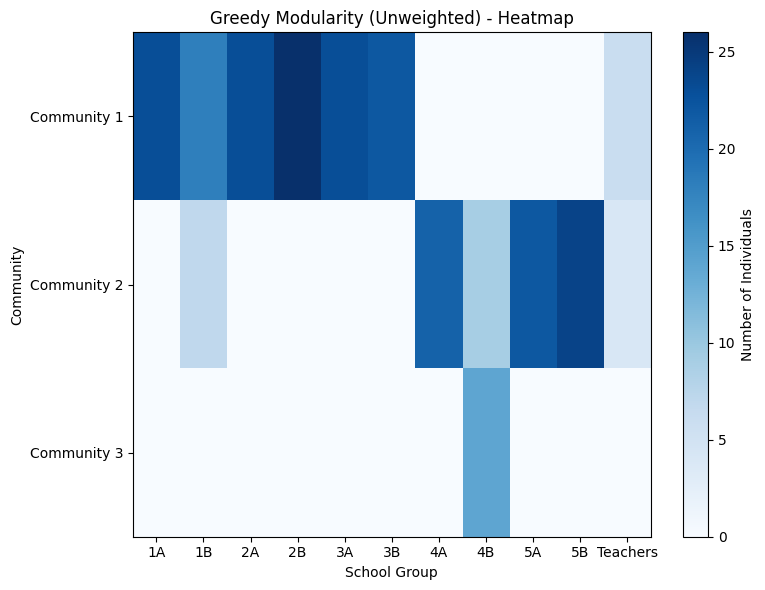

In [34]:
import pandas as pd
from collections import Counter

def plot_school_group_composition(communities, group_assignment, title_prefix="Community Composition by School Groups"):
    """
    Generates four different plots showing the composition of detected communities
    in terms of the school groups to which their individuals belong, using consistent
    colors for each school group.
    
    Parameters:
        communities (list of sets/lists): Detected communities, where each community is a collection of node identifiers.
        group_assignment (dict): Dictionary mapping each node to its corresponding school group.
        title_prefix (str): A prefix for the titles of the plots.
    
    The function produces:
      1. A Stacked Bar Plot.
      2. A set of Pie Charts (one per community).
      3. A Grouped Bar Chart.
      4. A Heatmap.
    """
    # Determine all unique school groups.
    all_groups = sorted(set(group_assignment.values()))
    
    # Generate a consistent color mapping for each school group.
    # Use a qualitative colormap ("tab10" for ≤10 groups, otherwise "tab20")
    cmap = plt.get_cmap("tab10") if len(all_groups) <= 10 else plt.get_cmap("tab20")
    color_mapping = {group: cmap(i) for i, group in enumerate(all_groups)}
    
    # Build a DataFrame where each row represents a community and each column a school group.
    community_labels = [f"Community {i+1}" for i in range(len(communities))]
    data = []
    for community in communities:
        # Map nodes to their school groups.
        community_groups = map(lambda x: group_assignment.get(x), list(community))
        # Count the number of individuals in each group within the community.
        counts = Counter(community_groups)
        # Ensure all groups are represented in the counts, even if zero.
        counts = {group: counts.get(group, 0) for group in all_groups}
        data.append(counts)
    df = pd.DataFrame(data, index=community_labels)[all_groups]
    
    # -------------------------------
    # Plot 1: Stacked Bar Plot
    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', stacked=True, color=[color_mapping[group] for group in all_groups])
    plt.title(f"{title_prefix} - Stacked Bar Plot")
    plt.xlabel("Communities")
    plt.ylabel("Number of Individuals")
    plt.legend(title="School Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 2: Pie Charts for Each Community
    num_com = len(df.index)
    cols = min(num_com, 4)  # up to 4 columns
    rows = int(np.ceil(num_com / cols))
    fig2, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = np.atleast_1d(axs).flatten()
    
    for i, community in enumerate(df.index):
        ax = axs[i]
        counts = df.loc[community]
        counts = counts[counts > 0]  # drop zero counts for clarity
        
        # Ensure the pie chart uses consistent colors based on the school group.
        colors = [color_mapping[group] for group in counts.index]
        counts.plot(kind='pie', ax=ax, autopct='%1.1f%%',
                    startangle=90, counterclock=False, colors=colors)
        ax.set_ylabel("")
        ax.set_title(community)
    
    # Turn off any unused subplots.
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    fig2.suptitle(f"{title_prefix} - Pie Charts", y=1.02)
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 3: Grouped (Side-by-Side) Bar Chart
    plt.figure(figsize=(10, 6))
    df.plot(kind='bar', color=[color_mapping[group] for group in all_groups])
    plt.title(f"{title_prefix} - Grouped Bar Chart")
    plt.xlabel("Communities")
    plt.ylabel("Number of Individuals")
    plt.legend(title="School Group", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 4: Heatmap of the Composition
    # Note: The heatmap represents counts using a continuous color scale
    plt.figure(figsize=(8, 6))
    im = plt.imshow(df.values, cmap='Blues', aspect='auto')
    plt.xticks(ticks=np.arange(len(all_groups)), labels=all_groups)
    plt.yticks(ticks=np.arange(len(community_labels)), labels=community_labels)
    plt.xlabel("School Group")
    plt.ylabel("Community")
    plt.title(f"{title_prefix} - Heatmap")
    plt.colorbar(im, label="Number of Individuals")
    plt.tight_layout()
    plt.show()

def plot_all_community_compositions(methods, group_assignment):
    """
    Loops over the community detection methods and generates the four plots
    for both the weighted and unweighted community partitions.

    Parameters:
        methods (dict): Dictionary mapping community detection method names to a tuple of
                        (weighted_communities, unweighted_communities).
        group_assignment (dict): Dictionary mapping each node to its corresponding school group.
    """
    for method_name, (weighted_communities, unweighted_communities) in methods.items():
        # Plot for weighted communities
        print(f"Plotting for {method_name} - Weighted communities")
        plot_school_group_composition(weighted_communities, group_assignment, 
                                      title_prefix=f"{method_name} (Weighted)")

        # Plot for unweighted communities
        print(f"Plotting for {method_name} - Unweighted communities")
        plot_school_group_composition(unweighted_communities, group_assignment, 
                                      title_prefix=f"{method_name} (Unweighted)")
        
communities_infomap_weighted = run_infomap(G_w, use_weight=True)
communities_infomap_unweighted = run_infomap(G_u, use_weight=False)
communities_louvain_weighted = nx.community.louvain_communities(G_w, weight='weight')
communities_louvain_unweighted = nx.community.louvain_communities(G_u)
communities_greedy_weighted = nx.community.greedy_modularity_communities(G_w, weight='weight')
communities_greedy_unweighted = nx.community.greedy_modularity_communities(G_u)


# Then, define the dictionary of methods:

methods = {
    "Infomap": (communities_infomap_weighted, communities_infomap_unweighted),
    "Louvain": (communities_louvain_weighted, communities_louvain_unweighted),
    "Greedy Modularity": (communities_greedy_weighted, communities_greedy_unweighted),
}

plot_all_community_compositions(methods, metadata)

In [22]:


def generate_latex_table_from_communities(methods, G_w, G_u, golden_partition,
                                          caption="Community Detection Metrics for the Primary School Network",
                                          label="tab:real_network"):
    """
    Generates a LaTeX table summarizing community detection results.
    
    For each community detection method (key in methods), this function computes:
      - The number of communities and modularity score for both the weighted and unweighted networks.
      - The Normalized Mutual Information (NMI), normalized Variation of Information (nVI),
        and Jaccard Index (computed against the golden standard partition).
    
    Parameters:
      methods (dict): A dictionary mapping a method name to a tuple
                      (weighted_communities, unweighted_communities) where each is a list of node sets.
      G_w (networkx.Graph): The weighted network used for weighted partitions.
      G_u (networkx.Graph): The unweighted network used for unweighted partitions.
      golden_partition (list of sets): The ground-truth communities.
      caption (str): Caption for the LaTeX table.
      label (str): LaTeX label for table referencing.
      
    Returns:
      A string containing the full LaTeX table.
    """
    table_lines = []
    table_lines.append("\\begin{table}[htbp]")
    table_lines.append("\\centering")
    table_lines.append(f"\\caption{{{caption}}}")
    table_lines.append(f"\\label{{{label}}}")
    # Define column alignment: Method, Network Version, # Communities, Modularity, NMI, nVI, Jaccard Index.
    table_lines.append("\\begin{tabular}{@{}l l c c c c c@{}}")
    table_lines.append("\\toprule")
    table_lines.append("Method & Network Version & \\# Communities & Modularity ($Q$) & NMI & nVI & Jaccard Index \\\\ \\midrule")
    
    # prr is used here as a placeholder (e.g., 0) since it is not the focus of the table;
    # evaluation is done against the golden standard.
    dummy_prr = 0  
    for method, (communities_w, communities_u) in methods.items():
        # Evaluate weighted partition using the weighted graph G_w.
        metrics_w = evaluate_partition(golden_partition, communities_w, G_w, dummy_prr)
        # Evaluate unweighted partition using the unweighted graph G_u.
        metrics_u = evaluate_partition(golden_partition, communities_u, G_u, dummy_prr)
        
        row_w = (f"{method} & Weighted & {metrics_w['num_communities']} & "
                 f"{metrics_w['modularity']:.2f} & {metrics_w['normalized_mutual_information']:.2f} & "
                 f"{metrics_w['normalized_variation_of_information']:.2f} & {metrics_w['jaccard_index']:.2f} \\\\")
        row_u = (f"{method} & Unweighted & {metrics_u['num_communities']} & "
                 f"{metrics_u['modularity']:.2f} & {metrics_u['normalized_mutual_information']:.2f} & "
                 f"{metrics_u['normalized_variation_of_information']:.2f} & {metrics_u['jaccard_index']:.2f} \\\\")
        table_lines.append(row_w)
        table_lines.append(row_u)
    
    table_lines.append("\\bottomrule")
    table_lines.append("\\end{tabular}")
    table_lines.append("\\end{table}")
    
    return "\n".join(table_lines)

communities_infomap_weighted = run_infomap(G_w, use_weight=True)
communities_infomap_unweighted = run_infomap(G_u, use_weight=False)
communities_louvain_weighted = nx.community.louvain_communities(G_w, weight='weight')
communities_louvain_unweighted = nx.community.louvain_communities(G_u)
communities_greedy_weighted = nx.community.greedy_modularity_communities(G_w, weight='weight')
communities_greedy_unweighted = nx.community.greedy_modularity_communities(G_u)


# Then, define the dictionary of methods:

methods = {
    "Infomap": (communities_infomap_weighted, communities_infomap_unweighted),
    "Louvain": (communities_louvain_weighted, communities_louvain_unweighted),
    "Greedy Modularity": (communities_greedy_weighted, communities_greedy_unweighted),
}

latex_table = generate_latex_table_from_communities(methods, G_w, G_u, metadata_to_communities(G_u, attribute="school_group"))
print(latex_table)

\begin{table}[htbp]
\centering
\caption{Community Detection Metrics for the Primary School Network}
\label{tab:real_network}
\begin{tabular}{@{}l l c c c c c@{}}
\toprule
Method & Network Version & \# Communities & Modularity ($Q$) & NMI & nVI & Jaccard Index \\ \midrule
Infomap & Weighted & 8 & 0.66 & 0.87 & 0.10 & 0.63 \\
Infomap & Unweighted & 1 & 0.00 & 0.00 & 0.43 & 0.09 \\
Louvain & Weighted & 6 & 0.67 & 0.80 & 0.15 & 0.49 \\
Louvain & Unweighted & 6 & 0.28 & 0.80 & 0.15 & 0.46 \\
Greedy Modularity & Weighted & 6 & 0.67 & 0.81 & 0.14 & 0.50 \\
Greedy Modularity & Unweighted & 3 & 0.23 & 0.43 & 0.33 & 0.17 \\
\bottomrule
\end{tabular}
\end{table}


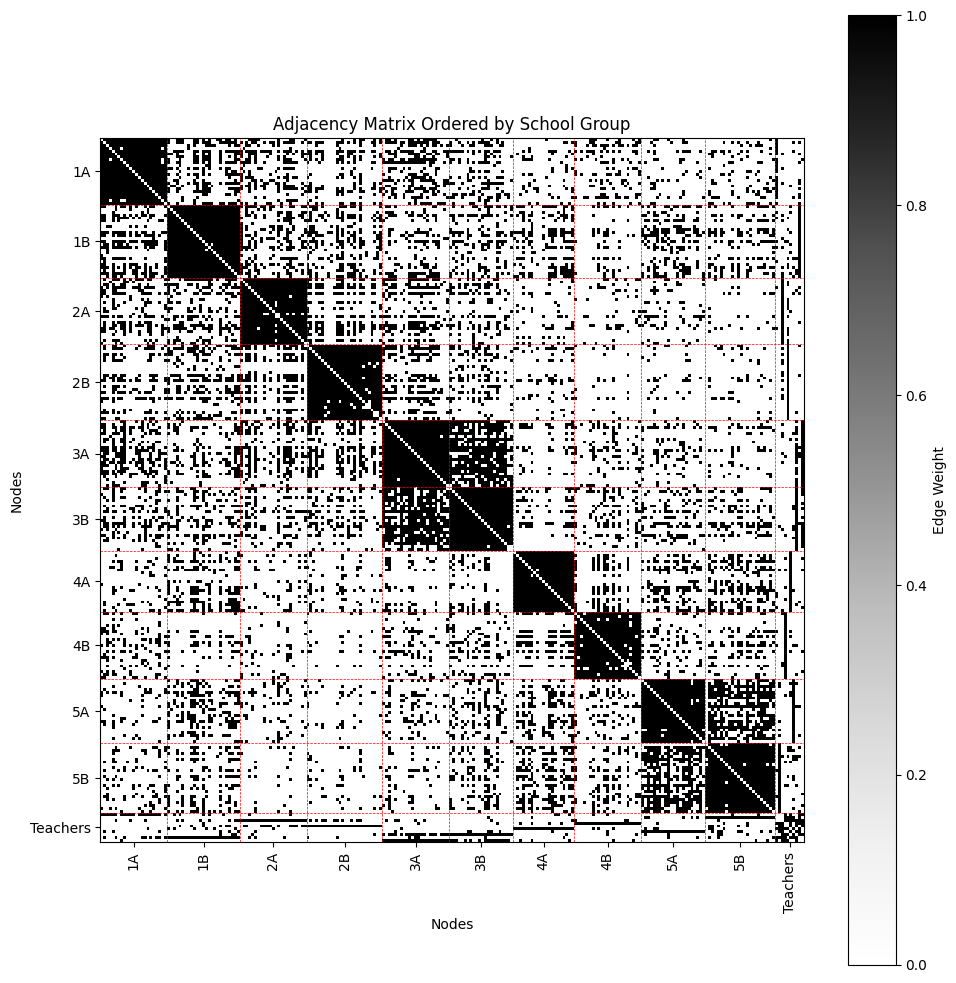

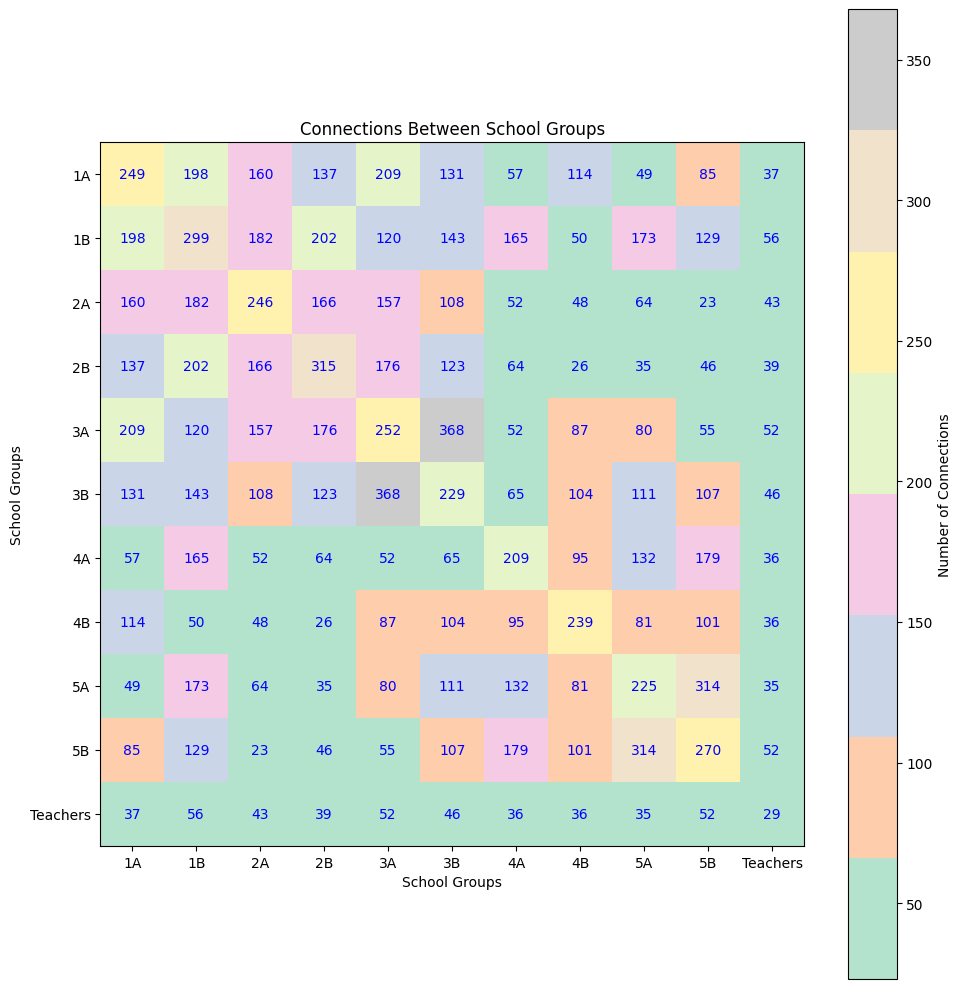

In [46]:
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Order nodes by their school group (using metadata)
sorted_nodes = sorted(G_u.nodes(), key=lambda node: (metadata.get(node, ""), node))

# Get the adjacency matrix of G_u for the sorted nodes
A = nx.to_numpy_array(G_u, nodelist=sorted_nodes)

plt.figure(figsize=(10, 10))
plt.imshow(A, interpolation='none', cmap='Greys')
plt.title("Adjacency Matrix Ordered by School Group")
plt.xlabel("Nodes")
plt.ylabel("Nodes")

# Get group labels for the sorted nodes
group_labels = [metadata.get(node, "") for node in sorted_nodes]

# Compute group boundaries and positions for ticks
group_positions = []
boundaries = []
for group, subiter in itertools.groupby(enumerate(group_labels), key=lambda x: x[1]):
    sublist = list(subiter)
    idx_start = sublist[0][0]
    idx_end = sublist[-1][0]
    mid = (idx_start + idx_end) / 2
    group_positions.append((group, mid))
    boundaries.append(idx_end + 0.5)
    
# Draw boundary lines to separate groups
for b in boundaries:
    plt.axhline(b, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(b, color='red', linestyle='--', linewidth=0.5)

# Set tick positions and labels at the center of each group block
groups, ticks = zip(*group_positions)
plt.xticks(ticks, groups, rotation=90)
plt.yticks(ticks, groups)

plt.colorbar(label="Edge Weight")
plt.tight_layout()
plt.show()


# --- New code: Compute and plot connection counts between different school groups ---

# Use the same groups order as in group_positions
groups_order = [group for group, _ in group_positions]
n_groups = len(groups_order)
conn_matrix = np.zeros((n_groups, n_groups), dtype=int)

# Iterate over all edges (each edge instance in the multigraph is counted)
for u, v, data in G_u.edges(data=True):
    gu = G_u.nodes[u]["school_group"]
    gv = G_u.nodes[v]["school_group"]
    if gu is None or gv is None:
        continue
    i = groups_order.index(gu)
    j = groups_order.index(gv)
    # For self connection add once; else add to symmetric entries.
    if i == j:
        conn_matrix[i, j] += 1
    else:
        conn_matrix[i, j] += 1
        conn_matrix[j, i] += 1

plt.figure(figsize=(10, 10))
plt.imshow(conn_matrix, cmap='Pastel2', interpolation='nearest')
plt.colorbar(label='Number of Connections')
plt.xticks(np.arange(n_groups), groups_order)
plt.yticks(np.arange(n_groups), groups_order)
plt.title("Connections Between School Groups")
plt.xlabel("School Groups")
plt.ylabel("School Groups")

# Add the actual value in each cell
for i in range(n_groups):
    for j in range(n_groups):
        plt.text(j, i, f"{conn_matrix[i, j]}", ha='center', va='center', color='b', fontsize=10)

plt.tight_layout()
plt.show()

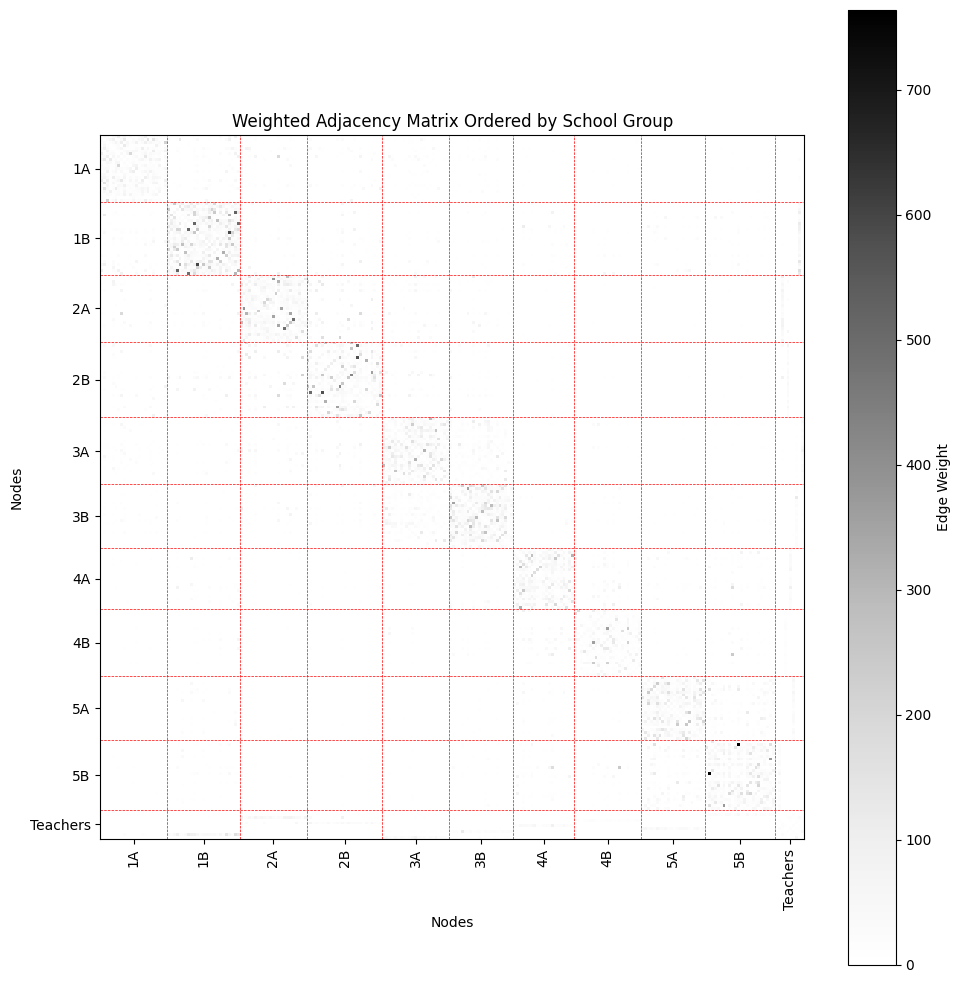

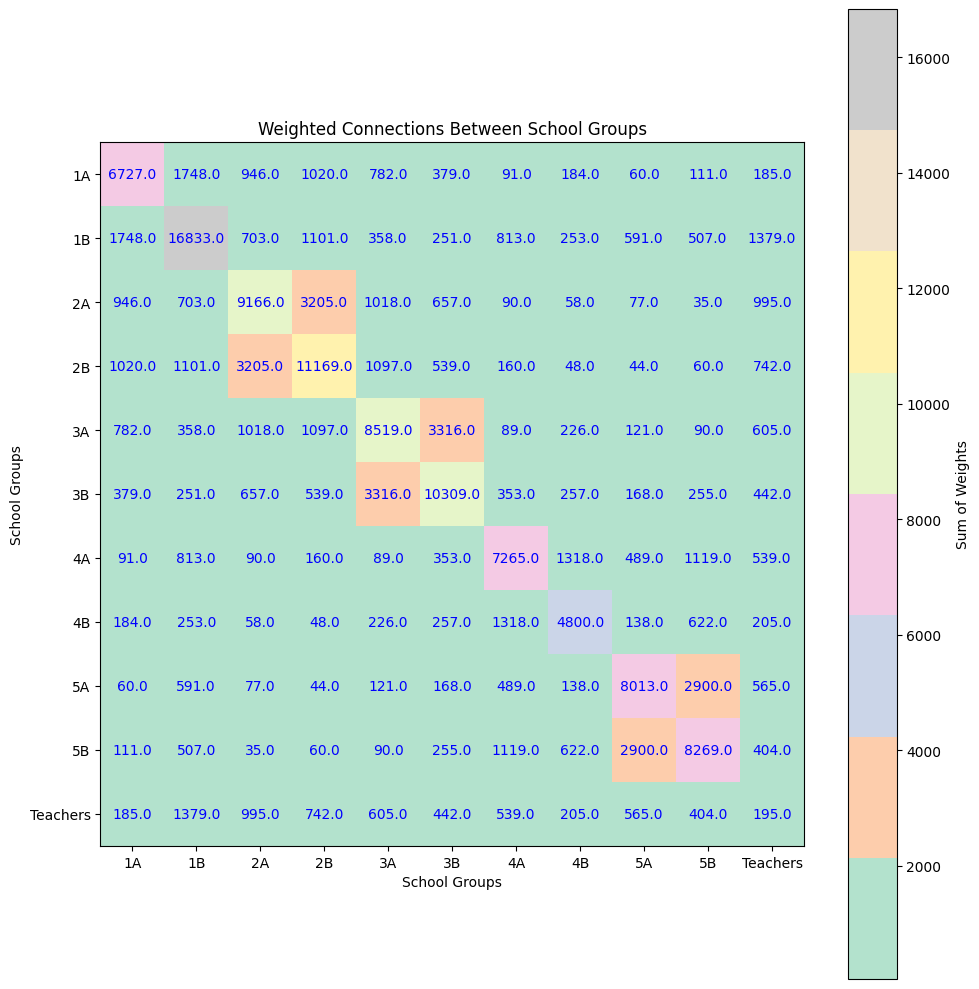

In [54]:
# Order nodes by their school group (using metadata)
sorted_nodes = sorted(G_w.nodes(), key=lambda node: (metadata.get(node, ""), node))

# Get the weighted adjacency matrix of G_w explicitly using the "weight" attribute
A = nx.to_numpy_array(G_w, nodelist=sorted_nodes, weight='weight')

plt.figure(figsize=(10, 10))
plt.imshow(A, interpolation='none', cmap='Greys')
plt.title("Weighted Adjacency Matrix Ordered by School Group")
plt.xlabel("Nodes")
plt.ylabel("Nodes")

# Get group labels for the sorted nodes
group_labels = [metadata.get(node, "") for node in sorted_nodes]

# Compute group boundaries and positions for tick labels
group_positions = []
boundaries = []
for group, subiter in itertools.groupby(enumerate(group_labels), key=lambda x: x[1]):
    sublist = list(subiter)
    idx_start = sublist[0][0]
    idx_end = sublist[-1][0]
    mid = (idx_start + idx_end) / 2
    group_positions.append((group, mid))
    boundaries.append(idx_end + 0.5)
    
# Draw boundary lines to separate groups
for b in boundaries:
    plt.axhline(b, color='red', linestyle='--', linewidth=0.5)
    plt.axvline(b, color='red', linestyle='--', linewidth=0.5)

# Set tick positions and labels at the center of each group block
groups, ticks = zip(*group_positions)
plt.xticks(ticks, groups, rotation=90)
plt.yticks(ticks, groups)

plt.colorbar(label="Edge Weight")
plt.tight_layout()
plt.show()


# --- New code: Compute and plot weighted connection sums between different school groups ---

# Use the same group order as in group_positions
groups_order = [group for group, _ in group_positions]
n_groups = len(groups_order)
conn_matrix = np.zeros((n_groups, n_groups), dtype=float)  # float type for accumulated weights

# Iterate over all edges and sum the weights for each pair of school groups
for u, v, data in G_w.edges(data=True):
    # Retrieve the school group for both nodes (if available)
    gu = G_w.nodes[u].get("school_group")
    gv = G_w.nodes[v].get("school_group")
    if gu is None or gv is None:
        continue
    weight = data.get("weight", 1)  # Use edge weight (default to 1 if not provided)
    i = groups_order.index(gu)
    j = groups_order.index(gv)
    # Add weight once for self connections; else add to both symmetric entries
    if i == j:
        conn_matrix[i, j] += weight
    else:
        conn_matrix[i, j] += weight
        conn_matrix[j, i] += weight

plt.figure(figsize=(10, 10))
plt.imshow(conn_matrix, cmap='Pastel2', interpolation='nearest')
plt.colorbar(label='Sum of Weights')
plt.xticks(np.arange(n_groups), groups_order)
plt.yticks(np.arange(n_groups), groups_order)
plt.title("Weighted Connections Between School Groups")
plt.xlabel("School Groups")
plt.ylabel("School Groups")

# Add the actual numerical value in each cell formatted to two decimals
for i in range(n_groups):
    for j in range(n_groups):
        plt.text(j, i, f"{conn_matrix[i, j]:.1f}", ha='center', va='center', color='b', fontsize=10)

plt.tight_layout()
plt.show()